## Capstone Project - RSNA Pneumonia Detection Challenge
**Problem Statement**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

**Dicom original images**: Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

**Here’s the backstory and why solving this problem matters**

**Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally.** In 2015, 920,000 children under the age of 5 died from the disease. In the United States, pneumonia accounts for over 500,000 visits to emergency departments and over 50,000 deaths in 2015, keeping the ailment on the list of top 10 causes of death in the country.

While common, accurately diagnosing pneumonia is a tall order. It requires review of a **chest radiograph (CXR)** by **highly trained specialists** and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the **diagnosis of pneumonia on CXR is complicated** because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

CXRs are the most commonly performed diagnostic imaging study. **A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.**


To improve the efficiency and reach of diagnostic services, the Radiological Society of North America (RSNA®) has reached out to Kaggle’s machine learning community and collaborated with the US National Institutes of Health, The Society of Thoracic Radiology, and MD.ai to develop a rich dataset for this challenge. ([Description Source](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/description))

**Data Source**: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

## Import Packages

In [1]:
# Mounting Google Drive   
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Install packages that aren't available by default in google colab
!pip install -q pydicom
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [0]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os, zipfile, random
import seaborn as sns
import pydicom as dcm
from glob import glob
%matplotlib inline

# SET VARIABLES
PATH = '/content/drive/My Drive/Pneumonia_Detection/'
TRAIN_IMAGES = 'stage_2_train_images/'
TEST_IMAGES = 'stage_2_test_images/'
COMPETITION_NAME = 'rsna-pneumonia-detection-challenge'
os.environ['KAGGLE_CONFIG_DIR'] = PATH
os.chdir(PATH)

# CUSTOM MODULE
from module_eda import *

In [0]:
## DOWNLOAD DATASET - Run this only if you haven't extracted the data yet
# !kaggle competitions download -c {COMPETITION_NAME}
# file_name = 'rsna-pneumonia-detection-challenge.zip'
# arc = zipfile.ZipFile(file_name, 'r')
# arc.extractall()
# print(f'Current working directory: {os.getcwd()}')
# print('Folder and Files in current directory: {os.listdir()}')

## Exploratory Data Analysis (EDA)
Here as a part of EDA, we will:
* Start with understanding of the data with a brief on train/test labels and respective class info
* Look at the first five rows of both the csvs (train and test)
* Identify how are classes and target distributed
* Check the number of patients with 1, 2, ... bounding boxes
* Read and extract metadata from dicom files
* Perform analysis on some of the features from dicom files
* Check some random images from the training dataset
* Draw insights from the data at various stages of EDA

### Reading CSVs
* Images for the current stage in the `stage_2_train_images` and `stage_2_test_images`.
* Training data: `stage_2_train_labels.csv`
* `stage_2_detailed_class_info.csv` containing detailed information about the positive and negative classes in the training set

In [5]:
print('--'*15, 'Reading Datasets (two csv files)', '--'*15)
train_labels = pd.read_csv('stage_2_train_labels.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

------------------------------ Reading Datasets (two csv files) ------------------------------
Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [6]:
print('--'*10, 'First five rows of both dataframes (train_labels, class_info)', '--'*10)
print('Train labels dataframe:\n'); display(train_labels.head())
print('\nClass info dataframe:\n'); display(class_info.head())

-------------------- First five rows of both dataframes (train_labels, class_info) --------------------
Train labels dataframe:



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1



Class info dataframe:



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [7]:
print('Numbers of nulls in bounding boxes columns are equal to the 0s we\'ve in Target column'); print('--'*40)
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Numbers of nulls in bounding boxes columns are equal to the 0s we've in Target column
--------------------------------------------------------------------------------
Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


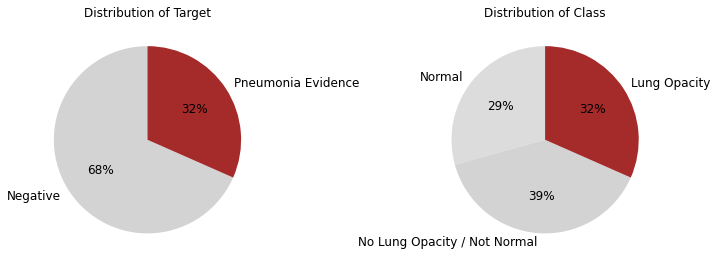

In [8]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

In [9]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*40)
bboxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bboxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(bboxes)))
print('\nNumber of patientIDs per bboxes in the dataset')
(bboxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Let's group by patient IDs and check number of bounding boxes for each unique patient ID
--------------------------------------------------------------------------------
Number of unique patient IDs in the dataset: 26684

Number of patientIDs per bboxes in the dataset


,number_of_patientIDs_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


In [10]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 8)


#### Observations from the CSVs
Based on analysis above, some of the observations:

* Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height.
* There are multiple records for patients. Number of duplicates in patientID = 3,543.
* There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia.
* Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity.
* Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class.
* Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class.
* About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!!!!

### Reading Images
Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images. 

In [11]:
sample_patient_id = train_labels['patientId'][0]
dcm_file = 'stage_2_train_images/{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

#### Observations from dicom image files
From the above sample we can see that dicom file contains some of the information that can be used for further analysis such as sex, age, body part examined (which should be mostly chest), view position and modality. Size of this image is 1024 x 1024 (rows x columns).

### Feature extraction from the dicom image files
Above we identified some features from the dicom files that can explored/used, let's focus on the following analysis from the image files
* To understand distribution of age for those with evidence of lung opacity and those with no definite evidence of lung opacity.
* To understand distribution of male and female for those with evidence of lung opacity and those with no definite evidence of lung opacity
* Explore different view positions in the dataset
* Explore modallity

To get the features from dicom image files, we will make use of function (`get_tags`) defined in (`module_eda`).

In [12]:
print('Read the training images file names and path'); print('--'*30)
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMAGES, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
------------------------------------------------------------
Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [13]:
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*30)
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))
del images

Merge path from the `images` dataframe with `train_class` dataframe
------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 9)


In [14]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
# get_tags(train_class, PATH + TRAIN_IMAGES)

print('Saving the feature engineered dataframe for future use'); print('--'*40)
# train_class.to_pickle('./output/train_feature_engineered.pkl')

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images
Saving the feature engineered dataframe for future use
--------------------------------------------------------------------------------


In [15]:
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [16]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,F,32.0,CHEST,AP,CR


In [17]:
print('As expected unique in `BodyPartExamined` is: {}'.format(train_class['BodyPartExamined'].unique()[0]))
print('Unique in `Modality` is: {}'.format(train_class['Modality'].unique()[0])); print('--'*40)

As expected unique in `BodyPartExamined` is: CHEST
Unique in `Modality` is: CR
--------------------------------------------------------------------------------


#### Understanding different View Positions
As seen below, two View Positions that are in the training dataset are AP (Anterior/Posterior) and PA (Posterior/Anterior). These type of X-rays are mostly used to obtain the front-view. Apart from front-view, a lateral image is usually taken to complement the front-view.

* **Posterior/Anterior (PA)**: In PA, X-Ray beam hits the posterior (back) part of the chest before the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film.
* **Anterior/Posterior (AP)**: Attimes it's not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. AP projection images are of lower quality than PA images. Heart size is exaggerated (cardiothoracic ratio approximately 50%) [[1](https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection#top_1st_img)].

<img src="assets/ap_pa.jpg">


Get the distribution of `ViewPosition` overall and where Target = 1
Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------


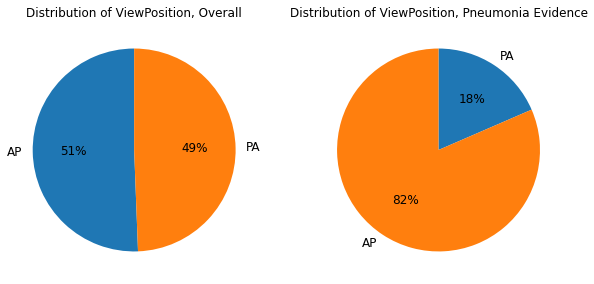

In [18]:
print('Get the distribution of `ViewPosition` overall and where Target = 1')
print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Exploring the bounding boxes for both view positions
* Centers of the rectangle would be x+width/2 and y+height/2 as also described in the reference link [*(source)*](https://stackoverflow.com/questions/32471199/why-is-the-center-of-a-rectangle-xwidth-2-yheight-2-in-java).
* We will make use of (`bboxes_scatter`) function in the (`module_eda`).
Reference for these plots and function [*(source)*](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda).

Plot x and y centers of bounding boxes
------------------------------------------------------------


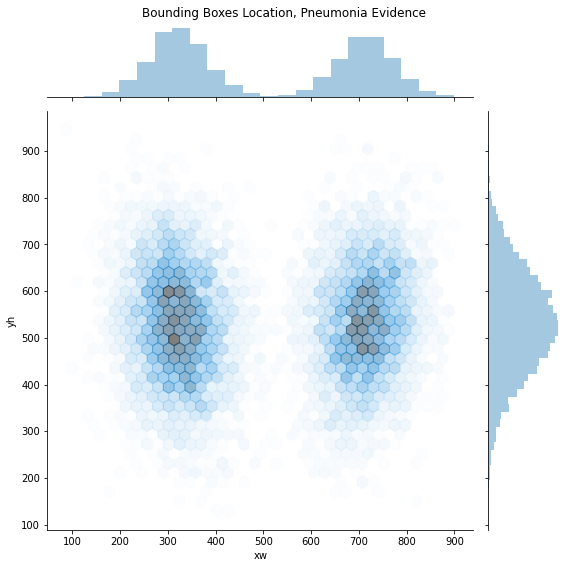

In [19]:
print('Plot x and y centers of bounding boxes'); print('--'*30)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000


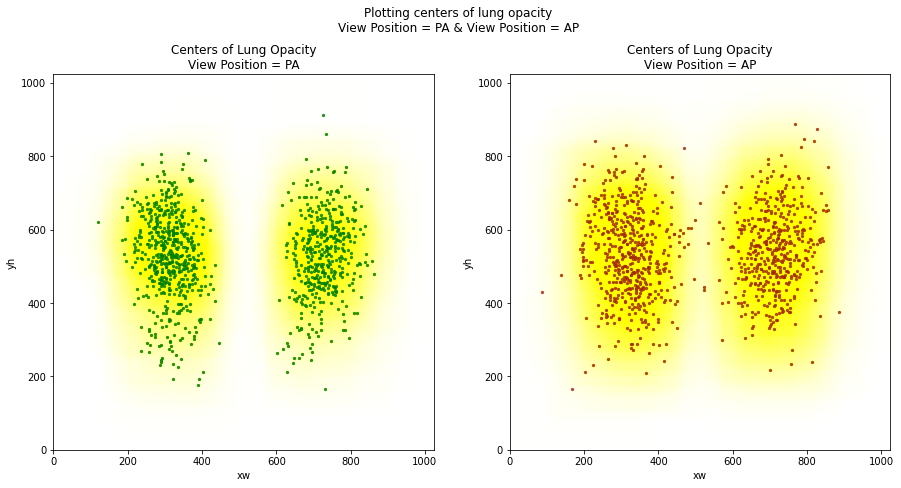

In [20]:
print('Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000')

df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

#### Observations: BodyPartExamined & ViewPosition
Above we saw,
* `BodyPartExamined` is unique for all cases and is CHEST in the training dataset and that was also expected.
* Unique in `Modality` is CR i.e. Computer Radiography
* Overall `ViewPosition` is almost equally distributed in the training dataset but for cases where `Target=1`, most of the view position are `AP`.

Checking outliers in `PatientAge
------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1.0
Maximum `PatientAge` in the training dataset: 155.0
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0



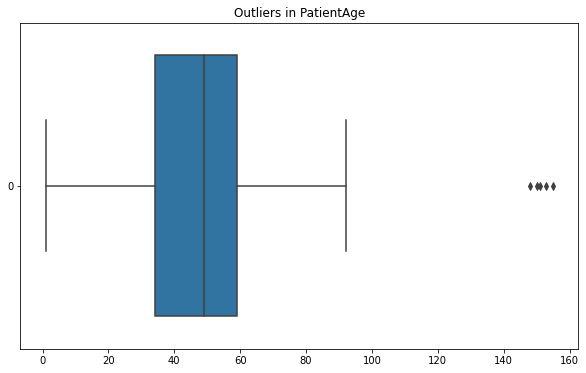

In [21]:
print('Checking outliers in `PatientAge'); print('--'*30)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of `pd.clip()` to trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [22]:
print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*30)
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

Using pd.clip to set upper threshold of 100 for age and remove outliers
------------------------------------------------------------


count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int64

Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------


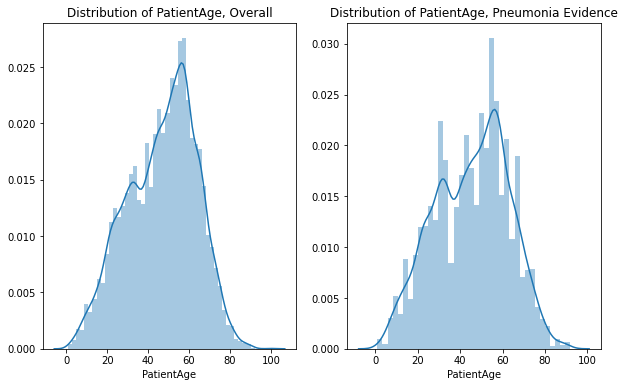

In [23]:
print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))

**Using Binning Method for `PatientAge` feature**

We'll make use of a `pd.cut` which is *'Bin values into discrete intervals'*. Use of this method is recommended when need is to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. Supports binning into an equal number of bins, or a pre-specified array of bins.

In [24]:
print('Creating Age Binning field', '--'*30)
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

Creating Age Binning field ------------------------------------------------------------


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Value counts of the age bin field created
--------------------------------------------------------------------------------


,"Counts of Age Bins, Overall","Counts of Age Bins, Target=1"
<=26,3972,1478
<=50,12157,3917
<=75,13318,3895
<=100,780,265


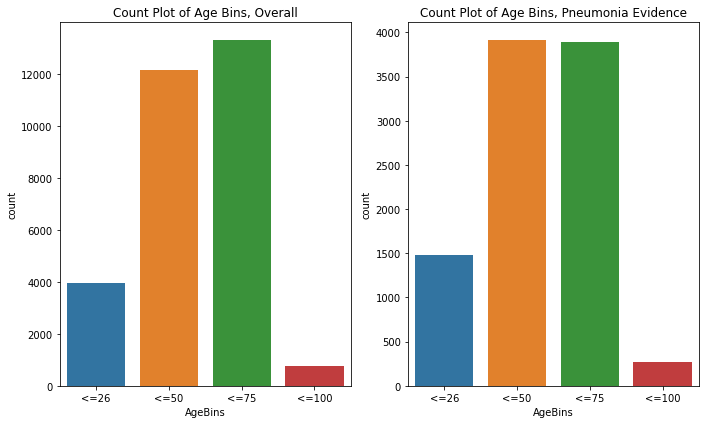

In [25]:
print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `AgeBins` for random sample = 200


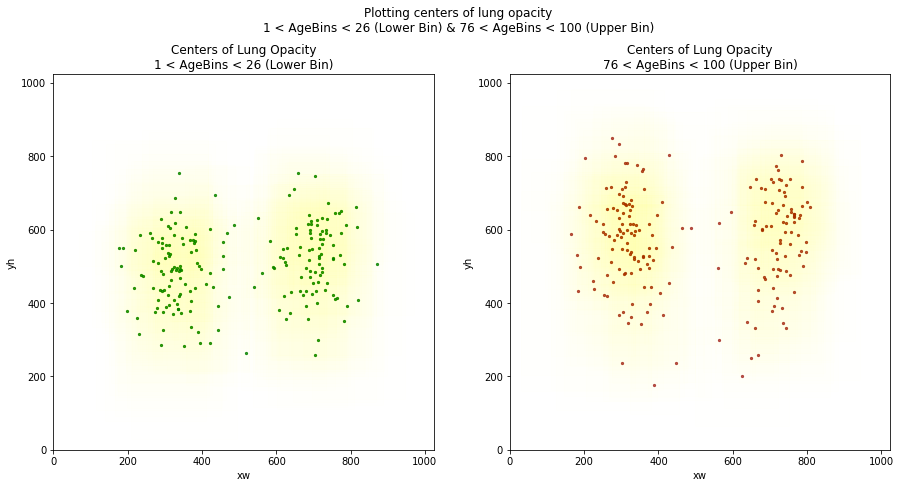

In [26]:
print('Exploring the bounding boxes centers for `AgeBins` for random sample = 200')
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '<=26'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')

Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender
--------------------------------------------------------------------------------


,"% Gender, Overall","% Gender, Target=1"
F,0.43,0.42
M,0.57,0.58


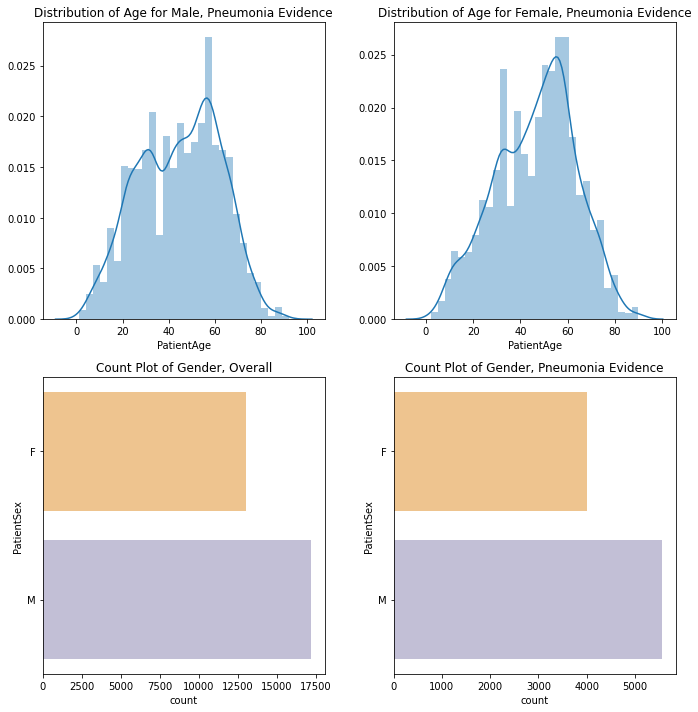

In [27]:
print('Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender'); print('--'*40)
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class.loc[(train_class['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `PatientSex` for random sample = 1000


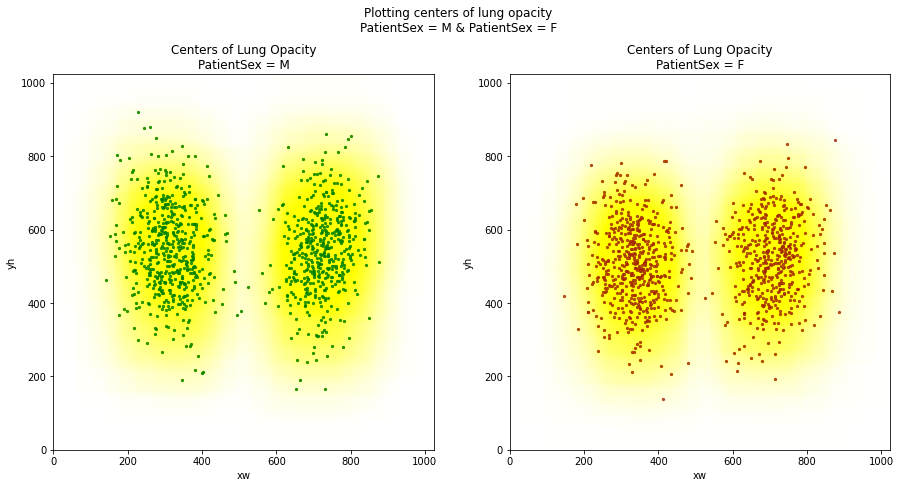

In [28]:
print('Exploring the bounding boxes centers for `PatientSex` for random sample = 1000')
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

#### Observations: PatientAge & PatientSex
Above we saw,
* For `PatientAge` we saw the distribution for both overall and where there were evidence of Pneumonia. Used binning to check the count of age bins. Count was highest for age group 40-78 both overall and with Pneumonia Evidence. 
* Saw distribution of age for Male and Female with Pneumonia Evidence.
* Dataset had more Males (57%-58%) than Females (42%-43%).

>Only `PatientAge`, `PatientSex` and `ViewPosition` are useful features from metadata.

Dropping the other features from `train_class` dataframe and save that as a pickle file 

In [29]:
train_class.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
train_class.shape

(30227, 12)

### Check some random samples from training data
Checking some random samples as below:
* Different classes i.e. Normal, No Lung Opacity / Not Normal and Lung Opacity
* Two view positions that we have in the dataset
* For the one with Pneumonia Evidence and age = 92

Now, we will make use of custom module (`module_eda`) and function (`plot_dicom_images`) already imported earlier to visualize the images.

Checking sample for different classes


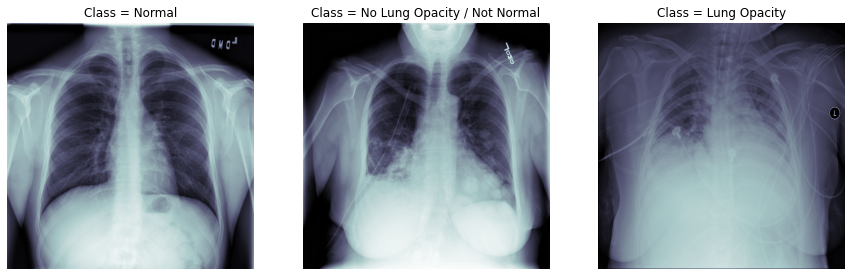

In [30]:
print('Checking sample for different classes')
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[0]
ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

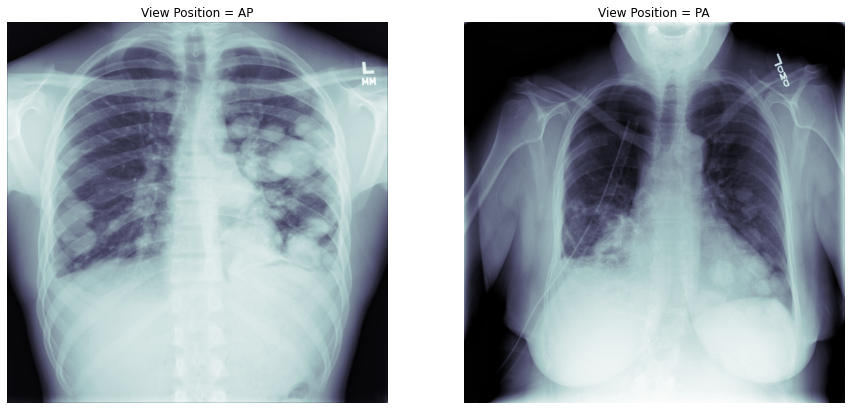

In [31]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]
ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

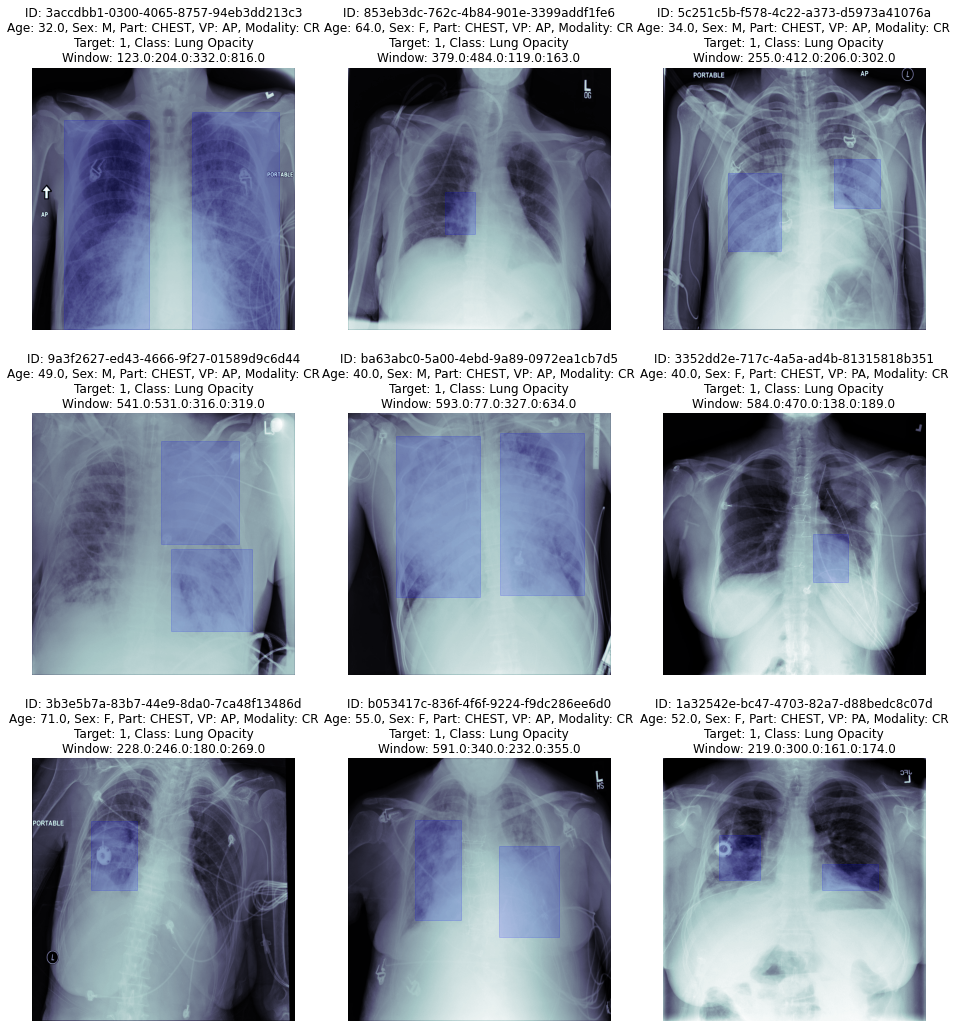

In [32]:
# this function is a part of custom module imported earlier (module_eda)
plot_dicom_images(train_class.loc[(train_class['Target'] == 1)].sample(9), train_class)